In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import mysql.connector

db=mysql.connector.connect(host="localhost",
                           username="root",
                           password= "123456",
                           database ="Ecommerse")

cur=db.cursor()


# List all unique cities where customers are located.

In [51]:
querry= """ select distinct customer_city from customers """


cur.execute(querry)
data=cur.fetchall()

df=pd.DataFrame(data ,columns=[" customer_city"])
df.head()

,customer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.


In [12]:
querry= """ select count(order_id) from orders where year(order_purchase_timestamp ) =2017 """


cur.execute(querry)
data=cur.fetchall()

"total order placed in 2017 are", data[0][0]

('total order placed in 2017 are', 45101)

# Calculate the percentage of orders that were paid in installments.


In [23]:
querry= """ select sum(case when payment_installments > 1 then 1
else 0 end)/count(*) *100 from payments """


cur.execute(querry)
data=cur.fetchall()

" the percentage of order that were paid in installments is", data[0][0]

(' the percentage of order that were paid in installments is',
 Decimal('49.4176'))

# Count the number of customers from each state. 


<function matplotlib.pyplot.show(close=None, block=None)>

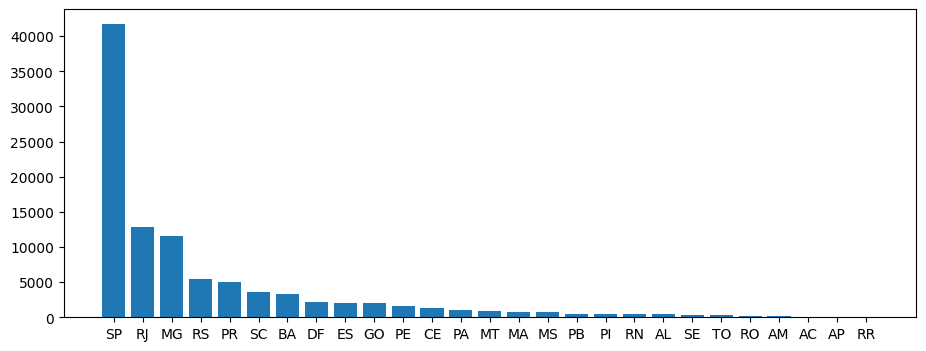

In [44]:
querry= """ select customer_state ,count(customer_id)
from customers
group by customer_state
"""


cur.execute(querry)
data=cur.fetchall()

df=pd.DataFrame(data,columns=["state","customer_count"])
df=df.sort_values(by="customer_count", ascending=False )


plt.figure(figsize=(11,4))
plt.bar(df["state"],df["customer_count"])
plt.xsticks=90
plt.show

# Calculate the number of orders per month in 2018.

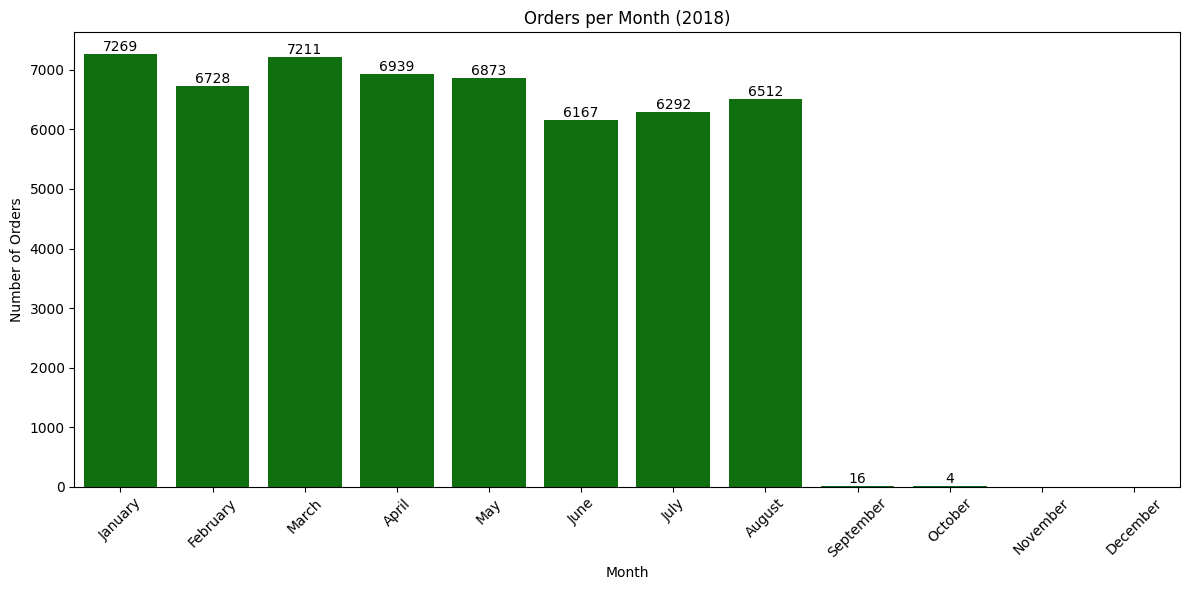

In [82]:
querry= """ select monthname(order_purchase_timestamp) months, count(order_id) order_counts from orders where  year(order_purchase_timestamp) =2018
group by months
"""


cur.execute(querry)
data=cur.fetchall()

df=pd.DataFrame(data,columns=["months","order_counts"])
o = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]


plt.figure(figsize=(12, 6))
ax=sns.barplot(x="months", y="order_counts", data=df, order=o ,color="green")

plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.title("Orders per Month (2018)")
plt.tight_layout()
plt.show()

# Find the average number of products per order, grouped by customer city.

In [5]:
query = """
SELECT 
    c.customer_city,
    ROUND(AVG(order_counts.product_count), 2) AS avg_products_per_order
FROM (
    SELECT 
        o.order_id,
        COUNT(oi.product_id) AS product_count,
        o.customer_id
    FROM orders o
    JOIN order_items oi ON o.order_id = oi.order_id
    GROUP BY o.order_id, o.customer_id
) AS order_counts
JOIN customers c ON c.customer_id = order_counts.customer_id
GROUP BY c.customer_city
ORDER BY avg_products_per_order DESC;
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["customer_city", "avg_products_per_order"])
df


,customer_city,avg_products_per_order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
...,...,...
4105,lagoa da canoa,1.00
4106,japaratuba,1.00
4107,sebastiao leal,1.00
4108,morro agudo de goias,1.00


# Calculate the total revenue generated by each seller

In [13]:
querry= """ select order_items.seller_id ,sum(payments.payment_value)
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id
"""


cur.execute(querry)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["seller_id","paymeny_value"])
df



,seller_id,paymeny_value
0,dd7ddc04e1b6c2c614352b383efe2d36,16061.360107
1,cc419e0650a3c5ba77189a1882b7556a,141309.580055
2,1f50f920176fa81dab994f9023523100,290253.420128
3,822bad9bc42b51213ba522fe87b7ab5d,5774.740028
4,cea729054f157f5870bdd321a958d994,3458.130013
...,...,...
3090,3e51f9cbe317bc3a88f2c76583811ee4,84.779999
3091,499185655c29ecfdbfe776ef7cf875b5,106.330002
3092,e908c0f3646e8b60375734a350d95d71,3009.530029
3093,497709c2976a8fa308730a2dec5b0726,188.080002


# Identify the top 3 customers who spent the most money in each year.

In [3]:
query = """
SELECT 
    YEAR(o.order_purchase_timestamp) AS order_year,
    o.customer_id,
    SUM(p.payment_value) AS total_payment,
    DENSE_RANK() OVER (
        PARTITION BY YEAR(o.order_purchase_timestamp)
        ORDER BY SUM(p.payment_value) DESC
    ) AS payment_rank
FROM 
    orders o
JOIN 
    payments p 
    ON o.order_id = p.order_id
GROUP BY 
    YEAR(o.order_purchase_timestamp), o.customer_id
ORDER BY 
    order_year, payment_rank;
"""

cur.execute(query)
data = cur.fetchall()

df=pd.DataFrame(data, columns=["order_year", "customer_id", "total_payment", "payment_rank"])
df

,order_year,customer_id,total_payment,payment_rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.550049,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.739990,2
2,2016,4a06381959b6670756de02e07b83815f,1227.780029,3
3,2016,1fc56719b52f82c03caddc5faf531fbb,982.409973,4
4,2016,85f0e92957e9fb9c5f72ba5378f492a0,979.909973,5
...,...,...,...,...
99435,2018,8e4bd65db637116b6b68109e4df21b84,10.890000,20895
99436,2018,a790343ca6f3fee08112d678b43aa7c5,9.590000,20896
99437,2018,a73c1f73f5772cf801434bf984b0b1a7,0.000000,20897
99438,2018,197a2a6a77da93f678ea0d379f21da0a,0.000000,20897


# Find total revenue generated per month in 2018

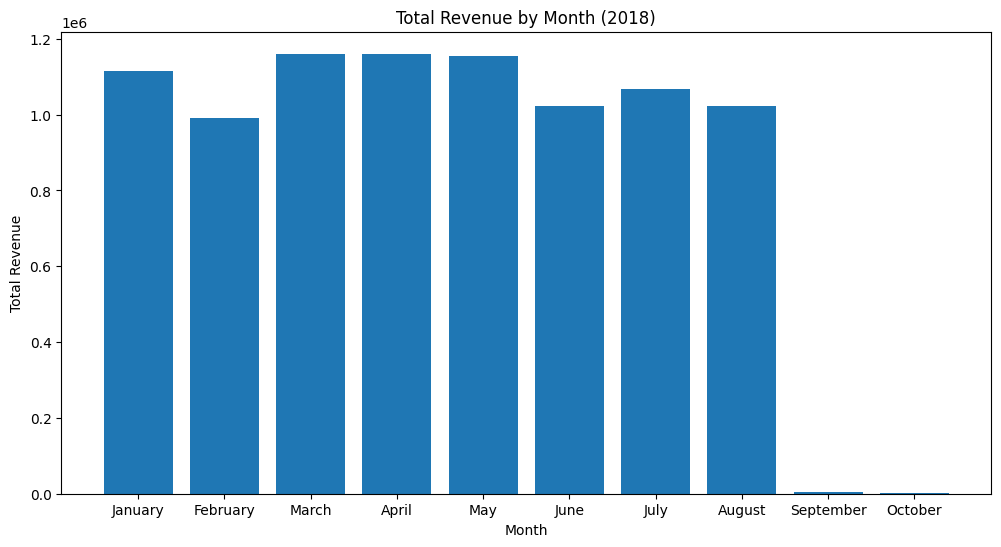

In [9]:
query = """
SELECT 
    MONTHNAME(order_purchase_timestamp) AS month_name,
    ROUND(SUM(payment_value), 2) AS total_revenue
FROM orders
JOIN payments ON orders.order_id = payments.order_id
WHERE YEAR(order_purchase_timestamp) = 2018
GROUP BY MONTH(order_purchase_timestamp), MONTHNAME(order_purchase_timestamp)
ORDER BY MONTH(order_purchase_timestamp);
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["month_name", "total_revenue"])
plt.figure(figsize=(12, 6))
plt.bar(df["month_name"], df["total_revenue"])
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.title("Total Revenue by Month (2018)")
plt.show()